In [35]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import re
import spacy
nlp = spacy.load('de_core_news_sm')
import seaborn as sns
import matplotlib.pyplot as plt

linebreak_pattern_1 = re.compile(r"-\n\d+\n", re.DOTALL)
linebreak_pattern_2 = re.compile(r"-\n", re.DOTALL)
space_pattern = re.compile(r"\n|\x0c|\x07|\x08|\xad|\xa0|\u200a|\t|\.|\,|\/", re.DOTALL)
word_pattern = re.compile(r"[a-zA-Z üäößÜÖÄ]", re.DOTALL)
whitespace_pattern = re.compile(r"\s+")

political_vocabulary = [
    'freiheit',
    'gleich',
    'solidar',
    'sozial',
    'privatisier',
    'leistung',
    'heimat',
    'mitbestimm',
    'nachhaltig',
    'umwelt',
    'armut',
    'diskriminier',
    'demokratisier',
    'digital',
    'klima',
    #-----
    'familie',
    'zuwander',
    'ezb',
    'national',
    'islam',
    #'bundesbank',
    #'verteidig',
    #'sozial',
    #'gesundheit',
    #'verbraucher',
    #-----
    'chance',
    'bevölker',
    'beschleunig',
    'modernisier',
    #'klima',
    'wachstum',
    #'weiterbild',
    #'marktwirtschaft',
    #'ehrenamt',
    #'industrieland',
    #-----
    'menschenrecht',
    'bürokrat',
    'innovation',
    'selbstständig',
    'liberal',
    #'marktwirtschaft',
    #'arbeitnehmer',
    #'kraftstoff',
    #'nachrichtendienst',
    #'wachstum',
    #-----
    'respekt',
    #'solidar',
    'jugendlich',
    'krise',
    'engagement',
    'gewerkschaft',
    #'zivilgesellschaft',
    #'nachhaltig',
    #'gleichstell',
    #'menschenrecht',
    #-----
    'klimakrise',
    'sozialökolog',
    'geflüchtet',
    'klimaneutral',
    'weiterbild',
    #'vorantreib',
    #'invest',
    #'stadt',
    #'vielf',
    #'mobilitätswende',
    #-----
    'beschäftigt',
    'konzern',
    'gerecht',
    'wohn',
    'löhne','lohn',
    #'klimagerechtigkeit',
    #'krieg',
    #'queer',
    #'reich',
    #'osten'
]

parties = {
    'linke':[],
    'grüne':[],
    'spd':[],
    'fdp':[],
    'cdu_csu':[],
    'afd':[],   
}

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'ZEIT ONLINE',
    'Der Tagesspiegel',
    'ARD',
    #'Tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

In [14]:
def extract_party_phrase_counts(party):
    with open(f"../assets/manifests/{party}_manifest.txt", encoding="utf-8", errors="ignore") as d:
        manifest = d.read()
    manifest = re.sub(linebreak_pattern_1, "", manifest)
    manifest = re.sub(linebreak_pattern_2, "", manifest)
    manifest = re.sub(space_pattern, " ", manifest)
    manifest = "".join(re.findall(word_pattern, manifest))
    manifest = re.sub(whitespace_pattern, " ", manifest)
    with nlp.select_pipes(enable="lemmatizer"):
        doc = nlp(manifest)
    lemmas = [token.lemma_.lower() for token in doc]
    manifest_vocabulary = [lemma for lemma in lemmas if lemma.isalpha()]
    phrase_counts = {phrase: 0 for phrase in political_vocabulary}
    for political_phrase in political_vocabulary:
        for manifest_phrase in manifest_vocabulary:
            if manifest_phrase.__contains__(political_phrase):
                phrase_counts[political_phrase] += 1
    phrase_counts['total'] = len(manifest_vocabulary)
    return pd.Series(phrase_counts)

def extract_medium_phrase_counts(df, medium):
    phrase_counts = {phrase: 0 for phrase in political_vocabulary}
    for doc in df[df['medium'] == medium]['transcript']:
        with nlp.select_pipes(enable="lemmatizer"):
            preprocessed = nlp(doc)
        lemmas = [token.lemma_.lower() for token in preprocessed]
        medium_vocabulary = [lemma for lemma in lemmas if lemma.isalpha()]
        for political_phrase in political_vocabulary:
            for medium_phrase in medium_vocabulary:
                if medium_phrase.__contains__(political_phrase):
                    phrase_counts[political_phrase] += 1
    return pd.Series(phrase_counts)

def standardize_df(input_df):
    df = input_df.copy()
    for party in parties.keys():
        df[party] -= df[party].mean()
    return df.round(3)

In [15]:
for party in parties.keys():
    with open(f"../assets/manifests/{party}_manifest.txt", encoding="utf-8", errors="ignore") as d:
        manifest = d.read()
    manifest = re.sub(linebreak_pattern_1, "", manifest)
    manifest = re.sub(linebreak_pattern_2, "", manifest)
    manifest = re.sub(space_pattern, " ", manifest)
    manifest = "".join(re.findall(word_pattern, manifest))
    manifest = re.sub(whitespace_pattern, " ", manifest)
    with nlp.select_pipes(enable="lemmatizer"):
        doc = nlp(manifest)
    lemmas = [token.lemma_.lower() for token in doc]
    parties[party] = [lemma for lemma in lemmas if lemma.isalpha()]

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(min_df=2, max_df=5)
test = vec.fit_transform([" ".join(i) for _, i in parties.items()])

In [17]:
n = 30
features = vec.get_feature_names_out()
for i in range(6):
    sorted = np.argsort(test[i,:].toarray()).flatten()[::-1]
    top_n = features[sorted][:n]
    print(f"party: {list(parties.keys())[i]}\ndiscriminative phrases:\n{top_n}\n")

party: linke
discriminative phrases:
['linke' 'kapitel' 'prozent' 'ver' 'solidarische' 'beschäftigte' 'umbau'
 'gewerkschaften' 'konzerne' 'gerechtigkeit' 'stoppen' 'wohnungen'
 'gerechte' 'liche' 'nen' 'löhne' 'klimagerechtigkeit' 'un' 'krieg' 'seit'
 'öffentlich' 'queere' 'klimaschutz' 'weiterbildung' 'sozialökologischen'
 'reichen' 'geflüchtete' 'bzw' 'osten' 'kämpfen']

party: grüne
discriminative phrases:
['grünen' 'bündnis' 'kapitel' 'bereit' 'ff' 'klimaschutz' 'bürgerinnen'
 'menschenrechte' 'klimakrise' 'prozent' 'faire' 'sozialökologische'
 'akteurinnen' 'überall' 'klare' 'zivilgesellschaft' 'geflüchteten'
 'chancen' 'jugendliche' 'schnell' 'klimaneutralität' 'weiterbildung'
 'vorantreiben' 'investieren' 'doch' 'stadt' 'vielfältige'
 'mobilitätswende' 'nachhaltigen' 'engagement']

party: spd
discriminative phrases:
['zukunftsprogramm' 'spd' 'kapitel' 'bürgerinnen' 'respekt' 'solidarität'
 'jugendliche' 'krise' 'engagement' 'arbeitnehmerinnen' 'chancen'
 'prozent' 'gewerkschaft

In [18]:
phrase_dict = {
    party:extract_party_phrase_counts(party) for party in tqdm(parties.keys())
}
party_df = pd.DataFrame(phrase_dict)

100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


In [19]:
df = pd.read_pickle('../data/topics_combined.pkl')
phrase_dict = {
    medium:extract_medium_phrase_counts(df, medium) for medium in tqdm(media)
}
media_df = pd.DataFrame(phrase_dict)

100%|██████████| 22/22 [32:13<00:00, 87.87s/it] 


In [20]:
party_similarity_dict = {}
for party in parties:
    medium_similarity_dict = {}
    for medium in media:
        medium_similarity_dict[medium] = cosine_similarity([party_df[party].iloc[:-1].to_list(), media_df[medium].to_list()])[0, 1]
    medium_series = pd.Series(medium_similarity_dict) 
    party_similarity_dict[party] = medium_series
similarity_df = pd.DataFrame(party_similarity_dict)

[Text(0.5, 50.09375, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'cosine similarity between party manifests and media tf-idf vocabulary')]

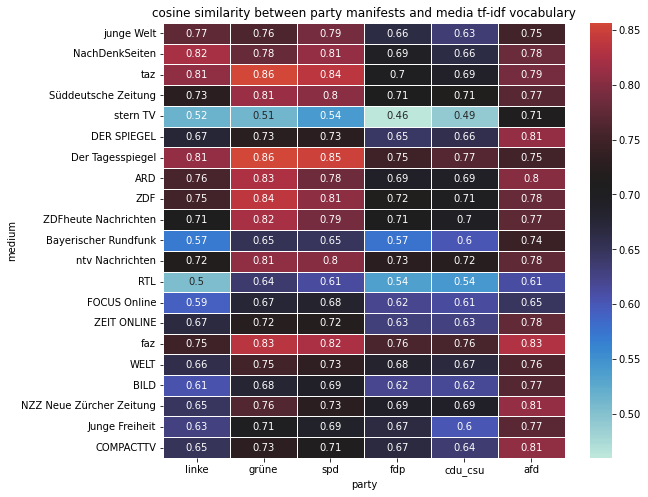

In [21]:
df_to_plot = similarity_df.drop('Tagesschau')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, linewidths=.5, ax=ax, fmt=".2", center=np.nanmean(df_to_plot))
ax.set(xlabel='party', ylabel='medium', title='cosine similarity between party manifests and media tf-idf vocabulary')

[Text(0.5, 50.09375, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'cosine similarity between party manifests and media tf-idf vocabulary, standardized')]

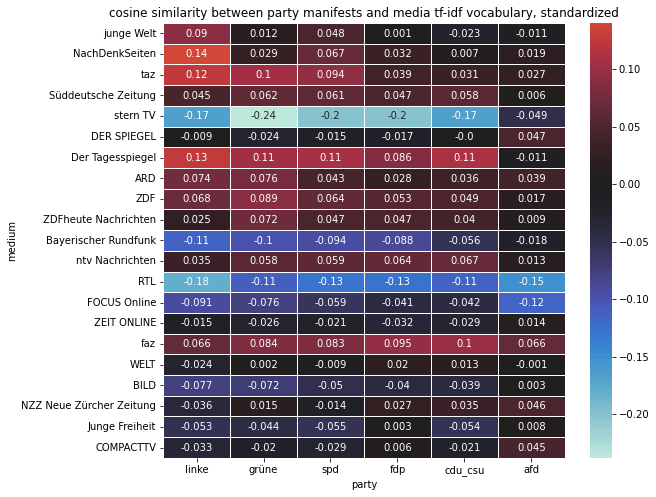

In [22]:
df_to_plot = standardize_df(similarity_df.drop('Tagesschau'))

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, linewidths=.5, ax=ax, fmt=".2", center=np.nanmean(df_to_plot))
ax.set(xlabel='party', ylabel='medium', title='cosine similarity between party manifests and media tf-idf vocabulary, standardized')

In [23]:
stats_df = similarity_df.drop('Tagesschau')
print(f"cosine similarity means:\n{stats_df.mean()}\n\ncosine similarity standard deviation:\n{stats_df.std()}")

cosine similarity means:
linke      0.682756
grüne      0.749957
spd        0.741970
fdp        0.662519
cdu_csu    0.656858
afd        0.762596
dtype: float64

cosine similarity standard deviation:
linke      0.092257
grüne      0.086659
spd        0.079319
fdp        0.071279
cdu_csu    0.067003
afd        0.051758
dtype: float64


In [39]:
similarity_df.drop('Tagesschau').loc[media].to_pickle('../data/vocabulary/tfidf.pkl')